# Simulation


### End2End Workflow of Task Completion 
--------------------------

In [1]:
#
from util import *
from dlg_manager import *
from alg import *
from agent import *
from user_sim import *
from state_tracker import *
import random
from config import *
import numpy as np
from nlg import *
from six.moves import cPickle as pickle
import IPython
import copy, argparse, json
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Load Data
-------------------

#### Action Set

In [2]:
#
act_set_path = './data/dia_acts.txt'
act_set = text_to_dict(act_set_path)
sample_dict(act_set)

keys = 11
Sample of dict:
- confirm_question: 2
- greeting: 4
- multiple_choice: 6
- request: 0
- closing: 5


### slot set

In [3]:
#
slots_set_path = "./data/slot_set.txt"
slot_set = text_to_dict(slots_set_path)
sample_dict(slot_set)

keys = 29
Sample of dict:
- distanceconstraints: 7
- critic_rating: 4
- starttime: 20
- seating: 19
- description: 6


### movie dic: info about movie

In [4]:
#
movie_kb_path = "./data/movie_kb.1k.p"
movie_kb = pickle.load(open(movie_kb_path, 'rb'), encoding="latin")
sample_dict(movie_kb, sample_size=1)

keys = 991
Sample of dict:
- 89: {'city': 'bellevue', 'theater': 'bellevue lincoln square cinemas', 'zip': '98004', 'distanceconstraints': 'near 98119', 'actor': 'ryan reynolds', 'date': 'tonight', 'state': 'wa', 'starttime': '8:15pm', 'genre': 'superhero', 'moviename': 'deadpool'}


# Language Generator (pretrained)
-------------------

In [5]:
#
nlg_model_path = './data/trained_model/nlg/lstm_tanh_relu_[1468202263.38]_2_0.610.p'
nlg_model = Nlg()
nlg_model.load_nlg_model(nlg_model_path)
diaact_nl_pairs_path = "./data/nlg/dia_act_nl_pairs.v6.json"
nlg_model.load_predefine_act_nl_pairs(diaact_nl_pairs_path)

## Model Params

In [6]:
#
model_params = pickle.load(open(nlg_model_path, 'rb'), encoding='latin1')
params = model_params['params']
print(params.keys())
print(params['split_method'])
print(params['write_model_dir'])

dict_keys(['grad_clip', 'dia_slot_val', 'reg_cost', 'data_path', 'save_check_point', 'slot_rep', 'max_epochs', 'sdgtype', 'init_rnn', 'cv_fold', 'write_model_dir', 'valid_test', 'pretrained_model_path', 'check_point', 'decay_rate', 'feed_recurrence', 'hidden_size', 'activation_func', 'momentum', 'learning_rate', 'batch_size', 'act_set', 'smooth_eps', 'split_method', 'slot_set', 'eva_metric', 'model'])
1
.\checkpoints\template\07102016\


# User Simulator
-------------------

### goal

In [7]:
#
goal_file_path = './data/user_goals_first_turn_template.part.movie.v1.p'
all_goal_set = pickle.load(open(goal_file_path, 'rb'), encoding="latin")
print("goals length: {}".format(len(all_goal_set)))
print("Sample the first goal: \n{}".format(all_goal_set[0]))

goals length: 128
Sample the first goal: 
{'request_slots': {}, 'diaact': 'request', 'inform_slots': {'city': 'birmingham', 'numberofpeople': '1', 'theater': 'carmike summit 16', 'state': 'al', 'starttime': 'around 2pm', 'date': 'today', 'moviename': 'zootopia'}}


### Split goal set

In [8]:
# split goal set
split_fold = params.get('split_fold', 5)
goal_set = {'train':[], 'valid':[], 'test':[], 'all':[]}
for u_goal_id, u_goal in enumerate(all_goal_set):
    if u_goal_id % split_fold == 1: goal_set['test'].append(u_goal)
    else: goal_set['train'].append(u_goal)
    goal_set['all'].append(u_goal)
print(len(goal_set['train']))
print(len(goal_set['valid']))
print(len(goal_set['test']))
print(len(goal_set['all']))

102
0
26
128


### user simulator param

In [9]:
#
usersim_params = {}
usersim_params['max_turn'] = 40
usersim_params['slot_err_prob'] = 0.05
# slot_err_mode: 0 for slot_val only; 1 for three errs
usersim_params['slot_err_mode'] = 0
usersim_params['intent_err_prob'] = 0
# run_mode: 0 for default NL; 1 for dia_act; 2 for both
usersim_params['run_mode'] = 0
# 0 for dia_act level; 1 for NL level
usersim_params['act_level'] = 0
# train/test/all; default is all
usersim_params['learn_phase'] = 'all'

### a movie dictionary for user simulator - slot:possible values

In [10]:
#
movie_dict_path = './data/user/dicts.v3.p'
movie_dictionary = pickle.load(open(movie_dict_path, 'rb'), encoding="latin")
samples = sample_dict(movie_dictionary, sample_size=1)

keys = 20
Sample of dict:
- video_format: ['3d', 'standard', '2d', 'standard/2D version', 'IMAX', 'imax', 'regular', 'imax 3d', ' standard']


###  Create a User

In [11]:
user = RuleSimulator(movie_dictionary, act_set, slot_set, goal_set, usersim_params)
user.set_nlg_model(nlg_model)

# Agent
-------------------

## param

In [12]:
#
agent_params = {}
# maximum length of each dialog (default=20, 0=no maximum length)
agent_params['max_turn'] = 20
# Epsilon to determine stochasticity of epsilon-greedy agent policies
agent_params['epsilon'] = 0
# run_mode: 0 for default NL; 1 for dia_act; 2 for both
agent_params['agent_run_mode'] = 3
# 0 for dia_act level; 1 for NL level
agent_params['agent_act_level'] = 0

############### DQN #################
# the size for experience replay
agent_params['experience_replay_pool_size'] = 10000
# # the hidden size for DQN
agent_params['dqn_hidden_size'] = 60
agent_params['batch_size'] = 16
# # gamma for DQN
agent_params['gamma'] = 0.9
# # predict model for DQN
agent_params['predict_mode'] = False
agent_params['trained_model_path'] = params['pretrained_model_path']
#####################################
print("pretrained model path = {}".format(agent_params['trained_model_path']))
# 0: no warm start; 1: warm start for training
agent_params['warm_start'] = 1
# run_mode: 0 for NL; 1 for dia_act
agent_params['cmd_input_mode'] = 0

pretrained model path = None


### create an agent

In [13]:
# agent = RequestBasicsAgent(movie_kb, act_set, slot_set, agent_params)
agent = AgentDQN(movie_kb, act_set, slot_set, agent_params)
agent.set_nlg_model(nlg_model)

agent_run_mode:3


# Dialog Manager
-------------------

In [14]:
dlg_manager = DlgManager(agent, user, act_set, slot_set, movie_kb)

## Running Episodes
-------------------

### Param

In [15]:
#
status = {'successes': 0, 'count': 0, 'cumulative_reward': 0}
# the size of validation set
simulation_epoch_size = 50
# the number of epochs for warm start 
warm_start_epochs = 100

In [16]:
def run_episodes(num_episode, status, verbose = False, record_training_data = True):
    num_success = 0
    accu_reward = 0.
    accu_episodes = 0.
    for i in range(1, num_episode+1):
#         print("\nEpisode {} starts!".format(i))
        dlg_manager.init_episode()
        done = False
        while not done:
            done, reward = dlg_manager.step()
            accu_reward += reward
            if done:
                if reward > 0: num_success += 1
                accu_episodes += dlg_manager.state_tracker.turn_count
#         print("Progress: %s / %s, Success rate: %s / %s Avg reward: %.2f Avg turns: %.2f" % (i+1, num_episode, num_success, i+1, float(accu_reward/(i+1)), float(accu_episodes)/(i+1)))
    succ_rate = num_success/num_episode
    if verbose: print("Success rate: %s / %s Avg reward: %.2f Avg turns: %.2f" % (num_success, num_episode, succ_rate, float(accu_episodes)/num_episode))
    status['successes'] += num_success
    status['count'] += num_episode
    return num_success, succ_rate

## Run !

In [17]:
num_episodes = 1
agt = 2
_, succ_rate = run_episodes(num_episodes, status, verbose = True, record_training_data=False)
display.HTML('<h3>{}</h3> '.format("Success Rate: {}".format(succ_rate)))

Success rate: 0 / 1 Avg reward: 0.00 Avg turns: 16.00


# Train & Eval
-------------------

In [18]:
def train_agent(num_episode = 100, num_batches = 100, batch_size = 10, status=status, eval_every = 10, show_every = 100):
    succ_rates = []
    num_succ = 0
    epochs = list(range(eval_every, num_episode+1, eval_every))
    for n_epo in epochs:
        # collect experience
        run_episodes(num_episode=eval_every, status=status, record_training_data = True)
        # train
        agent.train(batch_size=batch_size, num_batches=num_batches, show_every = show_every)
        # eval
        curr_num_succ, _ = run_episodes(num_episode=eval_every, status=status, record_training_data = False)
        num_succ += curr_num_succ
        succ_rates.append(num_succ/n_epo)
        
    return {"x": epochs, 'success_rate': succ_rates}

In [19]:
agent.clear_exp_pool()
succ_rates = train_agent(num_episode = 10, num_batches = 10, show_every = 1, eval_every = 1)

Train on : 8
cur bellman err 0.0000, experience replay pool 8
cur bellman err 0.0000, experience replay pool 8
cur bellman err 0.0000, experience replay pool 8
cur bellman err 0.0000, experience replay pool 8
cur bellman err 0.0000, experience replay pool 8
cur bellman err 0.0000, experience replay pool 8
cur bellman err 0.0000, experience replay pool 8
cur bellman err 0.0000, experience replay pool 8
cur bellman err 0.0000, experience replay pool 8
cur bellman err 0.0000, experience replay pool 8
Train on : 24
cur bellman err 13.4017, experience replay pool 24
cur bellman err 31.7344, experience replay pool 24
cur bellman err 21.0918, experience replay pool 24
cur bellman err 4.4258, experience replay pool 24
cur bellman err 7.9798, experience replay pool 24
cur bellman err 12.6815, experience replay pool 24
cur bellman err 0.0059, experience replay pool 24
cur bellman err 2.1656, experience replay pool 24
cur bellman err 1.8946, experience replay pool 24
cur bellman err 7.7861, exper

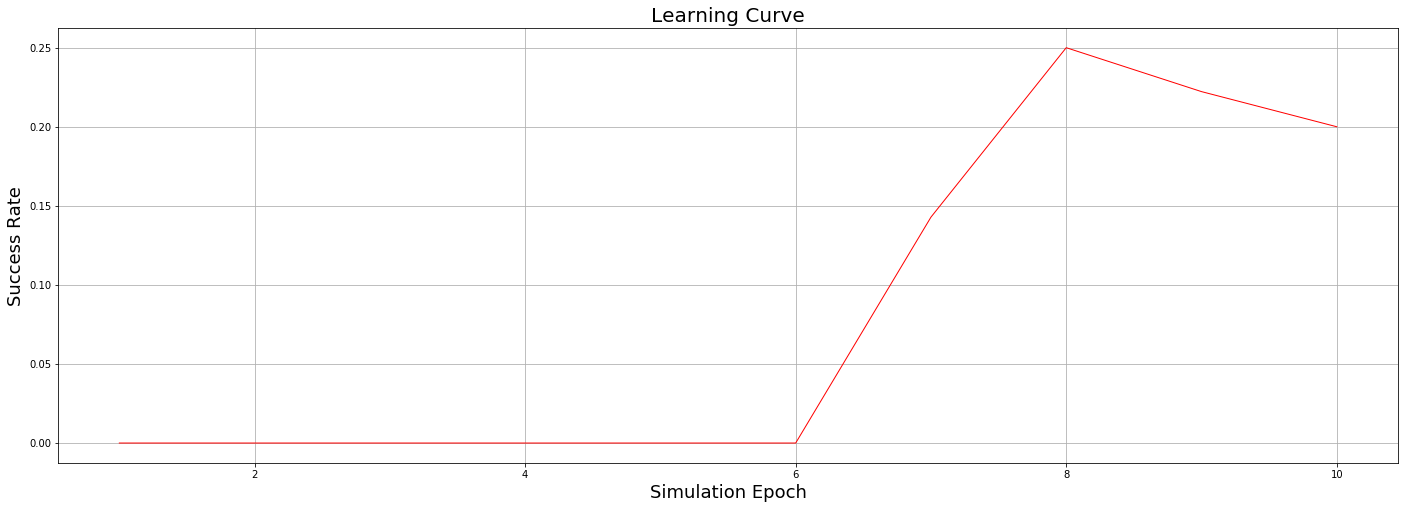

In [20]:
draw_learning_curve(succ_rates)